# DeepMeta : Graph Generation
This is an example to show how to generate some graphs from the output of the network.


In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import DeepMeta.predict as p
import DeepMeta.utils.data as data
import DeepMeta.utils.global_vars as gv
import DeepMeta.utils.utils as utils
import DeepMeta.postprocessing.post_process_and_count as post_count

%matplotlib inline

## Data preparation
First, we need to create a dataset containing our images. To handle easily different mutation we will create two lists representing each mutation. Each element will be a couple, composed by the full path of the image and it's name (we can find the name from the path, but since we already have it, it reduce the computation cost).

In [25]:
iL34 = []
LacZ = []
mouselist_il34 = ["44_2PLc_day22.tif", "45_2PLc_day29.tif", "46_2PLc_day36.tif", "47_2PLc_day43.tif", "48_2PLc_day50.tif", "49_2PLc_day57.tif", "50_2PLc_day64.tif", "51_2PLc_day71.tif", "52_2PLc_day78.tif", "53_2PLc_day85.tif", "54_2PLc_day92.tif", "55_2PLc_day99.tif", "56_2PLc_day106.tif", "57_2PLc_day113.tif", "58_2PLc_day120.tif"]
mouselist_LacZ = ["0_m2P_day6.tif", "1_m2P_day12.tif", "2_m2P_day19.tif", "3_m2P_day25.tif", "4_m2P_day32.tif",]

In [26]:
for mousename in mouselist_il34:
    MOUSE_PATH = os.path.join(gv.PATH_DATA, "Original_Data/iL34_1c", mousename)
    iL34.append((MOUSE_PATH, mousename))

for mousename in mouselist_LacZ:
    MOUSE_PATH = os.path.join(gv.PATH_DATA, "Original_Data/LacZ", mousename)
    LacZ.append((MOUSE_PATH, mousename))

## Function declaration

In this section, we will declare some function we will need to create the graph. 

First, `get_day` will help us to find the day in the mousename in order to put it in our csv later.

In [27]:
def get_day(mousename):
    return mousename.split('day')[1].split(".")[0]

The function above is just the processing done in `pipeline.py`, it runs inference on mouse images and return postprocessed masks.

In [28]:
def process_mouse(mouse, contrast=True):
    path_model_lungs = "../data/saved_models/Poumons/best_seg_model_weighted.h5"
    path_model_metas = "../data/saved_models/Metastases/best_seg_weighted.h5"
    utils.print_red(mouse[1])
    dataset = data.get_predict_dataset(mouse[0], contrast)

    seg_lungs = p.predict_seg(dataset, path_model_lungs).reshape(128, 128, 128)
    seg_lungs = p.postprocess_loop(seg_lungs)

    seg_metas = seg_lungs * p.predict_seg(dataset, path_model_metas).reshape(
        128, 128, 128
    )
    seg_metas = p.postprocess_meta(seg_metas, k1=3, k2=3)
    return seg_lungs, seg_metas

The function `process_value` is also some code from pipeline.py, this block process all volume informations we may want to use in plots.

In [29]:
def process_values(out_lungs, out_metas):
    vol = 0
    for mask in out_lungs:
        vol += post_count.vol_mask(mask)
    vol_meta = 0
    vol_per_meta = 0
    meta_slice = 0
    for i, meta_mask in enumerate(out_metas):
        if np.amax(meta_mask) == 1.0:
            vol_meta += post_count.vol_mask(meta_mask)
            vol_per_meta += post_count.mean_vol_per_meta(meta_mask)
            meta_slice += 1
    vol_per_meta /= meta_slice
    return vol, vol_meta, vol_per_meta

Last but not least, here are the function to create and fulfill the csv file. The csv header and the information we will write in should be matching, otherwise, the plot will fail. 

> Be carefull, the csv file you use should not exist

In [30]:
def write_in_csv(filename, mousename, day, vol_meta, mutation):
    check_and_create_file(filename)
    f = open(filename, "a")
    f.write(mousename + "," + day + "," + str(vol_meta) + "," + mutation + "\n")
    f.close()

def check_and_create_file(path):
    if not os.path.isfile(path):
        f = open(path, "a+")
        f.write("name,day,vol_meta,Mutation\n")
        f.close()

## Run and Draw

In [31]:
csv_path = "../data/results/lacz_vs_il34c2.csv"

for mouse in iL34:
    seg_lungs, seg_metas = process_mouse(mouse)
    vol, vol_meta, vol_per_meta = process_values(seg_lungs, seg_metas)
    write_in_csv(csv_path, mouse[1], get_day(mouse[1]), vol_meta, "il34c")

for mouse in LacZ:
    seg_lungs, seg_metas = process_mouse(mouse)
    vol, vol_meta, vol_per_meta = process_values(seg_lungs, seg_metas)
    write_in_csv(csv_path, mouse[1], get_day(mouse[1]), vol_meta, "LacZ")

44_2PLc_day22.tif
45_2PLc_day29.tif
46_2PLc_day36.tif
47_2PLc_day43.tif
48_2PLc_day50.tif
49_2PLc_day57.tif
50_2PLc_day64.tif
51_2PLc_day71.tif
52_2PLc_day78.tif
53_2PLc_day85.tif
54_2PLc_day92.tif
55_2PLc_day99.tif
56_2PLc_day106.tif
57_2PLc_day113.tif
58_2PLc_day120.tif
0_m2P_day6.tif
1_m2P_day12.tif
2_m2P_day19.tif
3_m2P_day25.tif
4_m2P_day32.tif


Once we have fulfill the csv, we can parse it with Pandas and use our dataframe to plot our graph.

In [32]:
data = pd.read_csv(csv_path)
df = pd.DataFrame(data)
print(df)

                  name  day  vol_meta Mutation
0    44_2PLc_day22.tif   22    4.3898    il34c
1    45_2PLc_day29.tif   29    6.9278    il34c
2    46_2PLc_day36.tif   36    4.3193    il34c
3    47_2PLc_day43.tif   43    4.7423    il34c
4    48_2PLc_day50.tif   50    9.2355    il34c
5    49_2PLc_day57.tif   57   10.8288    il34c
6    50_2PLc_day64.tif   64   13.6159    il34c
7    51_2PLc_day71.tif   71   19.1196    il34c
8    52_2PLc_day78.tif   78   33.7742    il34c
9    53_2PLc_day85.tif   85   31.6404    il34c
10   54_2PLc_day92.tif   92   48.6027    il34c
11   55_2PLc_day99.tif   99   65.9598    il34c
12  56_2PLc_day106.tif  106   86.7902    il34c
13  57_2PLc_day113.tif  113  118.1016    il34c
14  58_2PLc_day120.tif  120  149.8078    il34c
15      0_m2P_day6.tif    6    4.8833     LacZ
16     1_m2P_day12.tif   12    4.8739     LacZ
17     2_m2P_day19.tif   19   11.3740     LacZ
18     3_m2P_day25.tif   25   67.0079     LacZ
19     4_m2P_day32.tif   32   62.4630     LacZ


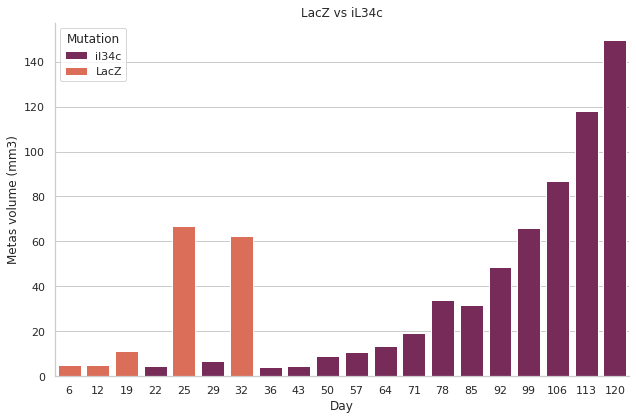

In [33]:
sns.set_theme(style="whitegrid")
ax = sns.catplot(x="day", y="vol_meta", hue="Mutation", data=df, kind="bar", ci=None, palette="rocket", height=6, aspect=1.5, dodge=False, legend_out=False)
ax.set(xlabel="Day", ylabel="Metas volume (mm3)", title="LacZ vs iL34c")
plt.tight_layout()
plt.show()
